## Import and Libraries

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
import glob
import tensorflow as tf

from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from keras.layers import Activation, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Reshape
from matplotlib import pyplot
from IPython.display import clear_output

import torchvision
import torchvision.transforms as transforms

from PIL import Image
import glob
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [43]:
np.random.seed(30)
seed = 30
tf.random.set_seed(30)

## Dataset

In [44]:
#import kagglehub
# Download latest version
#path = kagglehub.dataset_download("ikarus777/best-artworks-of-all-time")
#print("Path to dataset files:", path)

Found 8118 files belonging to 49 classes.
Using 5683 files for training.
Using 2435 files for validation.
training set size: 5683
validation set size: 1216
test set size: 1219


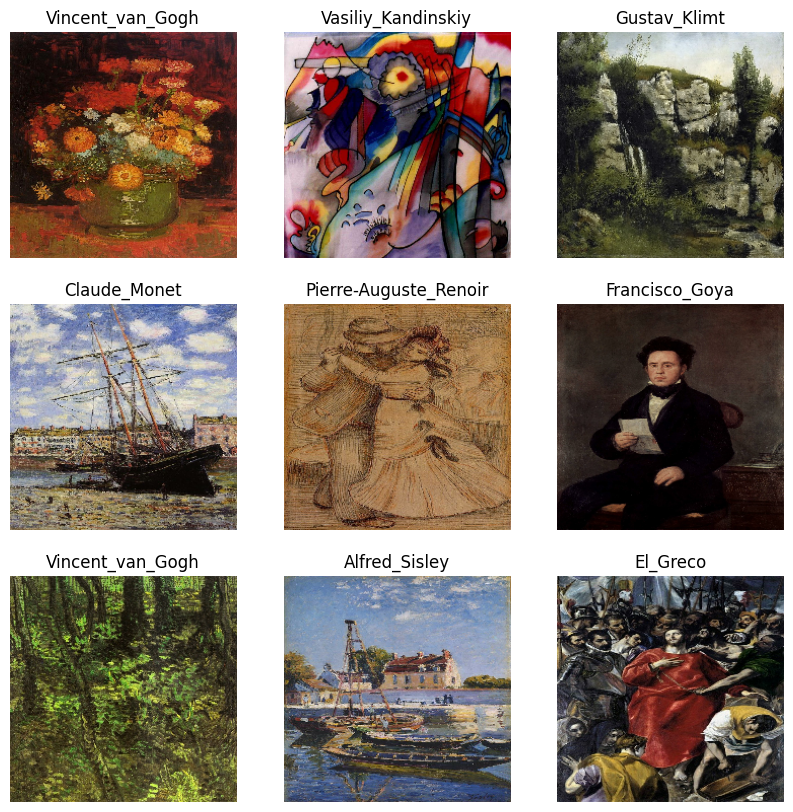

In [ ]:
path = "C:/Users/andre/Documents/Unimib/Magistrale/2anno/Digital Signal and Image Management/project/best-artworks-of-all-time/versions/1/images/images"
#path = "C:/Users/andre/Documents/Unimib/Magistrale/2anno/Digital Signal and Image Management/project/best-artworks-of-all-time/versions/1/images/images"

subfolders = glob.glob(pathname = f'{path}/*', recursive = True)

classes = []

for subfolder in subfolders:
    classes.append(subfolder.split(f'{path}\\')[1])

train, validation = keras.utils.image_dataset_from_directory(path,
                                                       image_size=(224,224),
                                                       batch_size=32,
                                                       label_mode='categorical',
                                                       subset='both',
                                                       validation_split = 0.30,
                                                       shuffle=True,
                                                       seed=22)

plt.figure(figsize=(10, 10))
for images, labels in validation.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

splitSize =  tf.data.experimental.cardinality(validation) // 2
test = validation.skip(splitSize)
validation = validation.take(splitSize)

print("training set size:", len(list(train.unbatch())))
print("validation set size:", len(list(validation.unbatch())))
print("test set size:", len(list(test.unbatch())))

## Turkish kebap

In [45]:
ARTWORK_PATH = "./best-artworks-of-all-time/versions/1/images/images"
ARTISTS_CSV = "./best-artworks-of-all-time/versions/1/artists.csv"
TARGET_GENRES = ['Surrealism', 'Realism', 'Post-Impressionism']
artists_df = pd.read_csv(ARTISTS_CSV)

selected_artists = artists_df[artists_df['genre'].str.contains('|'.join(TARGET_GENRES))]

# path 
image_paths = []
for artist in selected_artists['name']:
    artist_path = os.path.join(ARTWORK_PATH, artist.replace(' ', '_'))
    image_paths.extend(glob.glob(f"{artist_path}/*.jpg"))


IMG_SIZE = 64
def load_and_preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE)) 
        return (np.array(img) / 127.5) - 1 
    except Exception as e:
        print(f"Hata: {image_path}, {e}")
        return None
images = [load_and_preprocess_image(p) for p in image_paths]
images = np.array([img for img in images if img is not None])

In [46]:
selected_artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

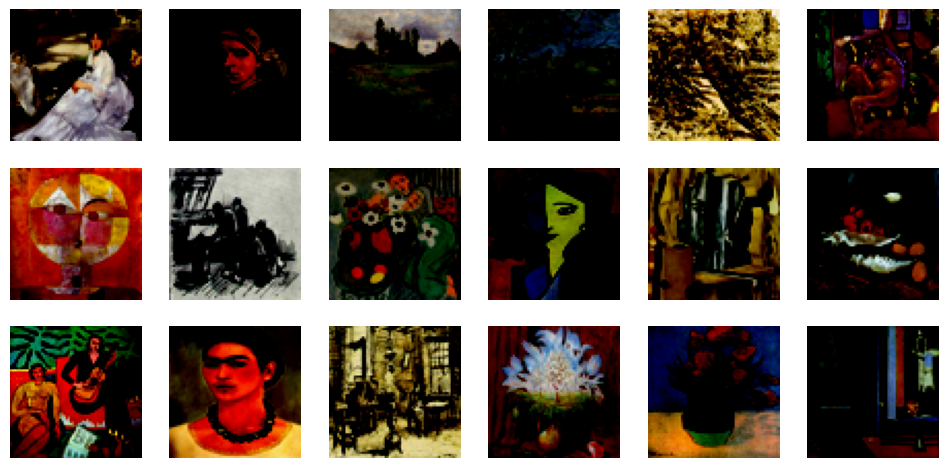

In [47]:
np.random.shuffle(images) #Shuffle the images

fig = plt.figure(figsize=(12,12))
for i in range(1,19):
    fig.add_subplot(6,6,i)
    plt.imshow(images[i])
    plt.axis('off')

In [48]:
def build_generator(seed_size=100, channels=3):
    model = Sequential()

    model.add(Dense(64 * 64, activation="relu", input_dim=seed_size))  
    model.add(Reshape((4, 4, 256))) 

    model.add(UpSampling2D()) 
    model.add(Conv2D(256, kernel_size=3, padding="same")) 
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D()) 
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Conv2D(256, kernel_size=3, padding="same")) 
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D(size=(2, 2))) 
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D(size=(2, 2))) 
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

In [49]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [50]:
SEED_SIZE = 100
IMAGE_CHANNELS = 3
IMG_SIZE = 64

generator = build_generator(SEED_SIZE,IMAGE_CHANNELS)

noise = tf.random.normal([1,SEED_SIZE])
generated_image = generator(noise,training=False)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
image_shape = (IMG_SIZE, IMG_SIZE, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50007874]], shape=(1, 1), dtype=float32)


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [52]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.2e-4, 0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.2e-4, 0.5)

In [53]:
GENERATED_ROWS = 7
GENERATED_COLS = 7
MARGIN = 2

def save_images(cnt, noise):
    image_array = np.full(( 
      2 + (7 * (IMG_SIZE + 2)), 
      2 + (7 * (IMG_SIZE + 2)), 3), 
      0, dtype=np.uint8)
    
    generated_images =  generator.predict(noise) 
    
    image_count = 0
    for row in range(GENERATED_ROWS):
        for col in range(GENERATED_COLS):
            r = row * (IMG_SIZE + 2) + MARGIN
            c = col * (IMG_SIZE + 2) + MARGIN
            image_array[r:r+IMG_SIZE , c:c+IMG_SIZE] = generated_images[image_count] * 127.5 + 127.5 
            image_count += 1
            
    output_path  = os.path.join("./best-artworks-of-all-time/generated/") 
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

In [54]:
BATCH_SIZE = 32

@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)
        
        real_output = discriminator(images, training=True)  
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gradients_of_generator = gen_tape.gradient(
            gen_loss,
            generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss, 
            discriminator.trainable_variables
        )
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    real_accuracy = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    disc_accuracy = (real_accuracy + fake_accuracy) / 2.0

    return gen_loss, disc_loss, disc_accuracy

In [56]:
BATCH_SIZE = 32
EPOCHS = 50

def train_process(dataset, epochs):
    history = {
        'gen_loss': [],
        'disc_loss': [],
        'disc_accuracy': []
    }
    
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        disc_acc_list = []
        
        for image_batch in dataset:
            gen_loss, disc_loss, disc_accuracy = train_step(image_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)
            disc_acc_list.append(disc_accuracy)
        
        g_loss = np.mean([x.numpy() for x in gen_loss_list])
        d_loss = np.mean([x.numpy() for x in disc_loss_list])
        d_acc = np.mean([x.numpy() for x in disc_acc_list])
        
        print(f"Epoch {epoch+1}, gen loss = {g_loss:.4f}, disc loss = {d_loss:.4f}, disc accuracy = {d_acc:.4f}")
        
        history['gen_loss'].append(g_loss)
        history['disc_loss'].append(d_loss)
        history['disc_accuracy'].append(d_acc)
        
        save_images(epoch, np.random.normal(0, 1, (GENERATED_ROWS * GENERATED_COLS, SEED_SIZE)))
    
    return history

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(images).batch(batch_size)

history = train_process(dataset, EPOCHS)

Epoch 1, gen loss = 1.1899, disc loss = 1.4760, disc accuracy = 0.6148
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Epoch 2, gen loss = 2.1334, disc loss = 1.0449, disc accuracy = 0.7776
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
Epoch 3, gen loss = 1.7274, disc loss = 1.3602, disc accuracy = 0.6874
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
Epoch 4, gen loss = 1.2071, disc loss = 2.0311, disc accuracy = 0.5568
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
Epoch 5, gen loss = 1.4075, disc loss = 1.5683, disc accuracy = 0.6275
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


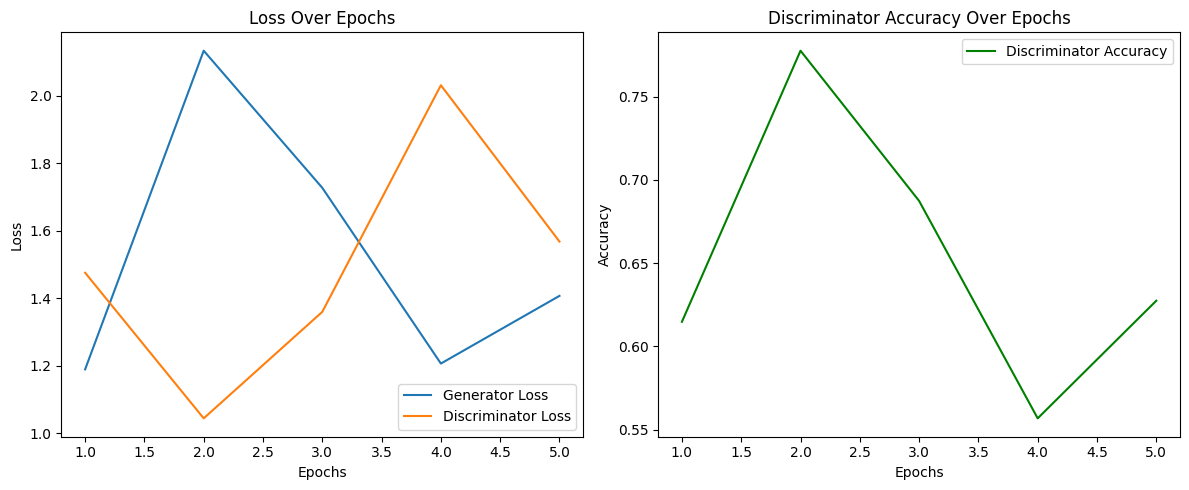

In [57]:
def plot_history(history):
    epochs = range(1, len(history['gen_loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['gen_loss'], label='Generator Loss')
    plt.plot(epochs, history['disc_loss'], label='Discriminator Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['disc_accuracy'], label='Discriminator Accuracy', color='green')
    plt.title('Discriminator Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

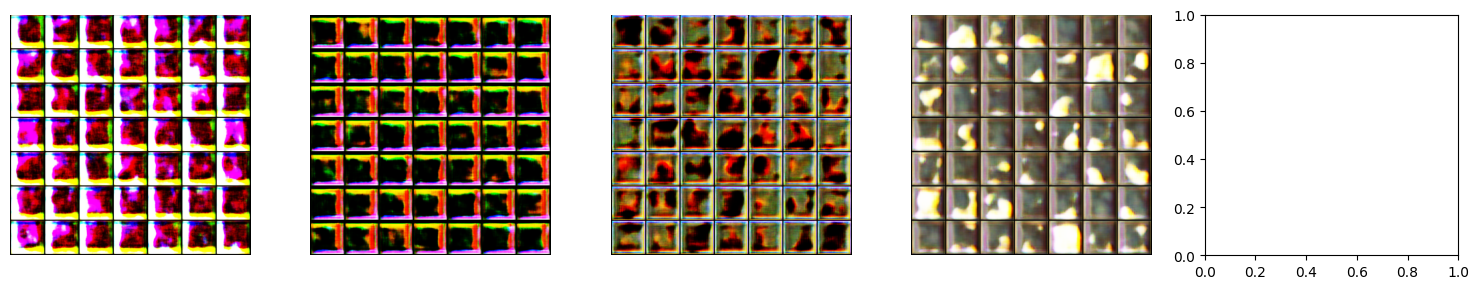

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def display_saved_images(paths, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    for ax, path in zip(axes.flatten(), paths):
        img = Image.open(path)
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

image_paths = [f"./best-artworks-of-all-time/generated/train-{i}.png" for i in range(0, EPOCHS)]

selected_paths = [image_paths[i] for i in [10, 20, 30, 40, 49]]

display_saved_images(selected_paths, rows=1, cols=5)

In [ ]:
# Generate final images
seed2 = tf.random.normal([BATCH_SIZE, SEED_SIZE])
generated_images2 = generator(seed2, training=True)
generated_images2 = 0.5 * generated_images2 + 0.5

# Display generated images
fig = plt.figure(figsize=(10, 10))
for i in range(1, 21):
    fig.add_subplot(5, 5, i)
    plt.imshow(generated_images2[i])
    plt.axis('off')
plt.show()